# Обработка комментариев

Заказчик - интернет-магазин - запускает новый сервис с возможность редактирования и дополнения описания товаров пользователями, которые могут предлагать свои правки и комментировать чужие. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

На наборе данных с разметкой о токсичности правок требуется обучить модель классифицировать комментарии на позитивные и негативные.

Целевая метрика - *F1*

**Ход выполнения**

1. Загрузка и подготовка данных.
2. Обучение моделей. 
3. Выводы.

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [129]:
data = pd.read_csv('toxic_comments.csv')
display(data)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


### Исследовательский анализ

In [130]:
print(data.isna().sum())

text     0
toxic    0
dtype: int64


In [131]:
print(data.duplicated().sum())

0


0    143346
1     16225
Name: toxic, dtype: int64
Процентное соотношение негативных комментариев 0    0.898321
1    0.101679
Name: toxic, dtype: float64
Процентное соотношение положительных комментариев 0    99.101679
1    99.898321
Name: toxic, dtype: float64


/Users/annatopilskaya/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='toxic'>

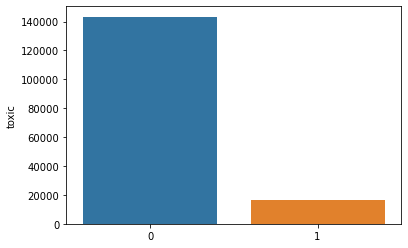

In [132]:
x = data['toxic'].value_counts()
print(x)
print('Процентное соотношение негативных комментариев', x/len(data['toxic']*100))
print('Процентное соотношение положительных комментариев', 100 - x/len(data['toxic']*100))
sns.barplot(x.index,x)

In [51]:
# количество слов
data['word_count'] = data['text'].apply(lambda x: len(str(x).split()))
print('Количество слов')
print('негативные комментарии', data[data['toxic']==1]['word_count'].mean()) 
print('позитивные комментарии', data[data['toxic']==0]['word_count'].mean()) 
print()

# количество символов
data['char_count'] = data['text'].apply(lambda x: len(str(x)))
print('Количество символов')
print('негативные комментарии', data[data['toxic']==1]['char_count'].mean()) 
print('позитивные комментарии', data[data['toxic']==0]['char_count'].mean()) 
print()

# количество уникальных слов
data['unique_word_count'] = data['text'].apply(lambda x: len(set(str(x).split())))
print('Количество уникальных слов')
print('негативные комментарии', data[data['toxic']==1]['unique_word_count'].mean()) 
print('позитивные комментарии', data[data['toxic']==0]['unique_word_count'].mean()) 

Количество слов
негативные комментарии 52.71771956856703
позитивные комментарии 68.92106511517586

Количество символов
негативные комментарии 303.30403697996917
позитивные комментарии 404.3471739706724

Количество уникальных слов
негативные комментарии 33.2231124807396
позитивные комментарии 49.78090075760747


**Вывод** 

В среднем, можно сделать вывод, что и количество слов, и количество символов, и количество уникальных слов в позитивных комментариях превышает все соотвутствующее в негативных комментариях.

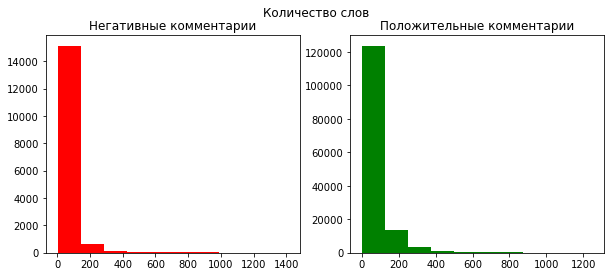

In [52]:
#построение графика кол-ва слов
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
neg_words=data[data['toxic']==1]['word_count']
ax1.hist(neg_words,color='red')
ax1.set_title('Негативные комментарии')
pos_words=data[data['toxic']==0]['word_count']
ax2.hist(pos_words,color='green')
ax2.set_title('Положительные комментарии')
fig.suptitle('Количество слов')
plt.show()

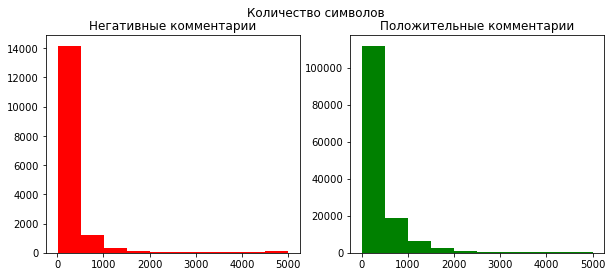

In [53]:
#построение графика кол-ва символов
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
neg_words=data[data['toxic']==1]['char_count']
ax1.hist(neg_words,color='red')
ax1.set_title('Негативные комментарии')
pos_words=data[data['toxic']==0]['char_count']
ax2.hist(pos_words,color='green')
ax2.set_title('Положительные комментарии')
fig.suptitle('Количество символов')
plt.show()

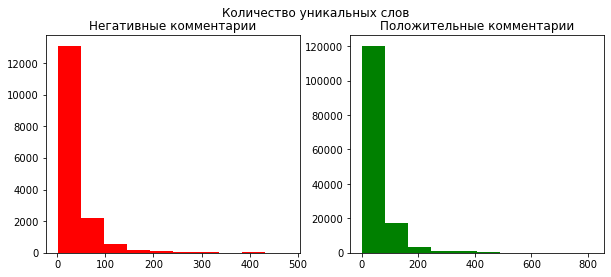

In [54]:
#построение графика кол-ва уникальных слов
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
neg_words=data[data['toxic']==1]['unique_word_count']
ax1.hist(neg_words,color='red')
ax1.set_title('Негативные комментарии')
pos_words=data[data['toxic']==0]['unique_word_count']
ax2.hist(pos_words,color='green')
ax2.set_title('Положительные комментарии')
fig.suptitle('Количество уникальных слов')
plt.show()

In [66]:
# обработка текста
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  adjacent spaces and tabs     .  "

# перевод текста в нижний регистр, удаление знаков препинания и лишних пробелов
def clean_text(text):
    text = text.lower() # нижний регистр
    text = text.strip()  # удаление начальных и конечных пробелов
    text = re.sub('\s+', ' ', text) # удаление лишних пробелов в тексте
    text = re.sub(r'\[[0-9]*\]',' ',text) #удаление цифр
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    
    
    return text

text=clean_text(text)
print(text)

this is a message to be cleaned it may involve some things like br adjacent spaces and tabs 


In [67]:
#удаление стоп-слов
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

text=stopword(text)
print(text)

message cleaned may involve things like br adjacent spaces tabs


In [70]:
#лемматизация
wl = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# токенизация
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) 
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

text = lemmatizer(text)
print(text)

message clean may involve thing like br adjacent space tab


In [72]:
%%time
#применение функции к датасету
def finalpreprocess(string):
    return lemmatizer(stopword(clean_text(string)))

data['clean_text'] = data['text'].apply(lambda x: finalpreprocess(x))
data.head()

CPU times: user 15min 53s, sys: 1min 38s, total: 17min 32s
Wall time: 17min 33s


,text,toxic,word_count,char_count,unique_word_count,clean_text
0,Explanation\nWhy the edits made under my usern...,0,43,264,41,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,17,112,17,daww match background colour im seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",0,42,233,39,hey man im really try edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,113,622,82,cant make real suggestion improvement wonder s...
4,"You, sir, are my hero. Any chance you remember...",0,13,67,13,sir hero chance remember page thats


In [82]:
data = data.drop(columns=['word_count','char_count','unique_word_count'])
display(data.head())

Index(['text', 'toxic', 'clean_text'], dtype='object')


## Обучение

In [85]:
# делю выборку на обучающую и тестовую
data_train, data_valid = train_test_split(data, test_size=0.2, random_state=42)

features_train = data_train['clean_text']
features_valid = data_valid['clean_text']

target_train = data_train['toxic']
target_valid = data_valid['toxic']

features_train_tok= [nltk.word_tokenize(i) for i in features_train]
features_valid_tok= [nltk.word_tokenize(i) for i in features_valid]

print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)
print(len(features_train_tok))
print(len(features_valid_tok))

(127656,)
(31915,)
(127656,)
(31915,)
127656
31915


In [102]:
#TF-IDF

tfidf_vectorizer = TfidfVectorizer(use_idf=True)

features_train_vectors_tfidf = tfidf_vectorizer.fit_transform(features_train)

features_valid_vectors_tfidf = tfidf_vectorizer.transform(features_valid) 

### Логистическая регрессия

In [112]:
lr_tfidf = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(features_train_vectors_tfidf, target_train)  #model

lr_predictions_valid = lr_tfidf.predict(features_valid_vectors_tfidf)
lr_f1 = f1_score(target_valid, lr_predictions_valid)
print('lr_f1 = ', lr_f1)  

lr_f1 =  0.7858864027538726


### Дерево решений

In [116]:
best_result = 0
best_depth = 0
for i in range(10,31):
    tree_tfidf = DecisionTreeClassifier(max_depth=i, random_state=42)
    tree_tfidf.fit(features_train_vectors_tfidf, target_train)
    tree_predictions_valid = tree_tfidf.predict(features_valid_vectors_tfidf)
    tree_f1 = f1_score(target_valid, tree_predictions_valid)
    print('max_depth =',i, 'tree_f1 =',tree_f1)
    if tree_f1 > best_result:
        best_result = tree_f1
        best_depth = i 
print('наилучший результат', best_result, 'достигается при глубине max_depth = ', best_depth )
tree_f1 = best_result

max_depth = 10 tree_f1 = 0.6057355064988653
max_depth = 11 tree_f1 = 0.612194621227674
max_depth = 12 tree_f1 = 0.6286173633440515
max_depth = 13 tree_f1 = 0.6277431044896316
max_depth = 14 tree_f1 = 0.6373626373626373
max_depth = 15 tree_f1 = 0.6421617325650706
max_depth = 16 tree_f1 = 0.6454293628808865
max_depth = 17 tree_f1 = 0.6541149068322981
max_depth = 18 tree_f1 = 0.6528941726758917
max_depth = 19 tree_f1 = 0.6595703502999807
max_depth = 20 tree_f1 = 0.6660250240615977
max_depth = 21 tree_f1 = 0.6666666666666666
max_depth = 22 tree_f1 = 0.6752802584077522
max_depth = 23 tree_f1 = 0.6757886735081717
max_depth = 24 tree_f1 = 0.6807387862796833
max_depth = 25 tree_f1 = 0.6785308595229079
max_depth = 26 tree_f1 = 0.6793233082706768
max_depth = 27 tree_f1 = 0.6859830667920979
max_depth = 28 tree_f1 = 0.6828351193833427
max_depth = 29 tree_f1 = 0.6856393933720278
max_depth = 30 tree_f1 = 0.6851920925027974
наилучший результат 0.6859830667920979 достигается при глубине max_depth =  2

### Случайный лес

In [123]:
# best_result = 0
# best_est = 0
# for i in range(100, 201, 10):
#     forest_tfidf = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=42)
#     forest_tfidf.fit(features_train_vectors_tfidf, target_train)
#     forest_predictions_valid = forest_tfidf.predict(features_valid_vectors_tfidf)
#     forest_f1 = f1_score(target_valid, forest_predictions_valid) 
#     print('best_est =',i, 'forest_f1 =',forest_f1)
#     if forest_f1 > best_result:
#         best_result = forest_f1
#         best_est = i 
# print('наилучший результат', best_result, 'достигается при глубине количестве деревьев = ', best_est)

forest_tfidf = RandomForestClassifier(random_state=42, max_depth=10,n_estimators=150)
forest_tfidf.fit(features_train_vectors_tfidf, target_train)
forest_predictions_valid = forest_tfidf.predict(features_valid_vectors_tfidf)
forest_f1 = f1_score(target_valid, forest_predictions_valid) 
print(forest_f1)

0.0


## Выводы

In [126]:
df_dict = {'model': ['tree', 'forest', 'log_reg'], 
           'f1': [tree_f1, forest_f1, lr_f1]
     }
df = pd.DataFrame(df_dict)
df = df.sort_values('f1', ascending=False)
display(df)

,model,f1
2,log_reg,0.785886
0,tree,0.685192
1,forest,0.000000


Таким образом, лучшим результатом f1 обладает логистическая регрессия.

**Общий вывод**

- Цель проекта

Заказчик - интернет-магазин - запускает новый сервис с возможность редактирования и дополнения описания товаров пользователями, которые могут предлагать свои правки и комментировать чужие. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

_На наборе данных с разметкой о токсичности правок требуется обучить модель классифицировать комментарии на позитивные и негативные._

Целевая метрика - *F1*

- Полученные данные и их предобработка

Получен датасет, в котором перечислены комментарии и их характеристика: негативные (toxic = 1) и позитивные (toxic = 0)

- Исследовательский анализ

        Процентное соотношение негативных комментариев 0.898321
    
        Процентное соотношение положительных комментариев 99.101679

    Среднее количество слов в комментарии
    
        негативные комментарии 52.71771956856703
        позитивные комментарии 68.92106511517586

    Среднее количество символов в комментарии
    
        негативные комментарии 303.30403697996917
        позитивные комментарии 404.3471739706724

    Среднее количество уникальных слов в комментарии
    
        негативные комментарии 33.2231124807396
        позитивные комментарии 49.78090075760747

- Обработка текста

Были написаны функции :

     очистки текста от знаков препинания, лишних пробелов, символов,
     удаления стоп-слов
     лемматизации текста

- Обучение

Разделила выборку на тестовую и валидационную, вычислила TF-IDF и обучила три модели:

    логистическая рергессия дала результат 0.7858864027538726
    
    дерево решений дало лучший результат 0.6859830667920979 при глубине 27 
    
    сулчайный лес дал результат 0 

- Общий вывод

    Самый лучшие результаты показывает логистическая регрессия lr_f1 =  0.7858864027538726